# **Présentation Game Of Life**


# Partie A : Moteur de Jeu

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
from numba import cuda
from PIL import Image, ImageOps
from typing import Callable
from pathlib import Path
from threading import Lock
import math
from uuid import UUID
import uuid
import pygame
from render.Utils import fitRatio, centerCoord

pygame 2.6.1 (SDL 2.30.7, Python 3.11.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Le moteur de jeu est contenu dans la classe `Board`.

Les méthodes implémentées dans cette classe permettent la création d'une image composée de cellules vivantes et mortes, puis la génération d'autres images montrant l'avancée du jeu suivant les règles suivantes:

- Une cellule morte possédant exactement trois cellules voisines vivantes devient vivante
- Une cellule vivante ne possédant pas exactement deux ou trois cellules voisines vivantes meurt.

Dans la classe `Board`:

- Les méthodes `__new__` et `__init__` permettent de créer et d'initialiser un nouveau tableau, comprennant des cellules mortes et vivantes, avec une répartition random du nombre de cellules mortes et vivantes ou non.

- La méthode `updateCPU` permet de rendre l'image suivant l'image actuelle du tableau, pour se faire, elle calcule l'état de chaque cellule en comptant ses voisines vivantes avec la méthode `countAlive`.

- La méthode `tick`utilise la méthode `updateCPU` pour générer le prochaine état des cellules en gardant en mémoire avec une classe `Lock` l'état précédent, afin de n'afficher le nouvel état qu'une fois qu'il est généré, ce qui peut prendre quelques millisecondes sur le CPU. Ell utilise aussi la méthode `refresh` pour rafraîchir l'écran après la génération de l'image suivante.

- Les méthodes `paste`, `getSize` et `getAliveCount` sont utilisées plus tard dans des composants complexes.
- Enfin la méthode `getImage` transforme le tableau généré en image (.png) en vérifiant la transparence, la couleur et en coupant les bordures du tableau qui sont utilisées pour sa création.

Dans cette présentation, la méthode `getImage` est appelée avec les méthodes `imgshow` et `show` de la bibliothèque `MatPlotLib` pour afficher 5 images

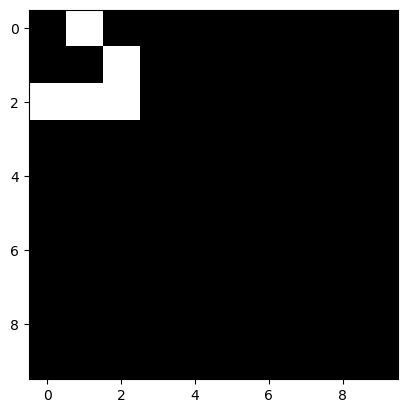

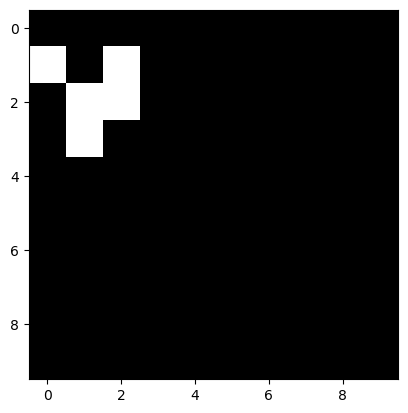

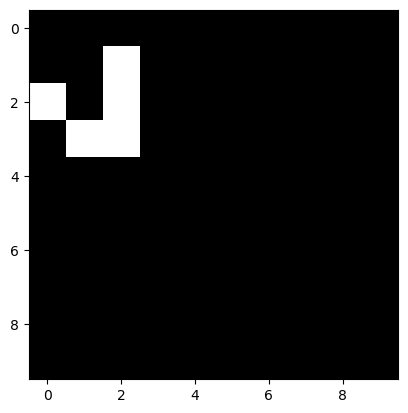

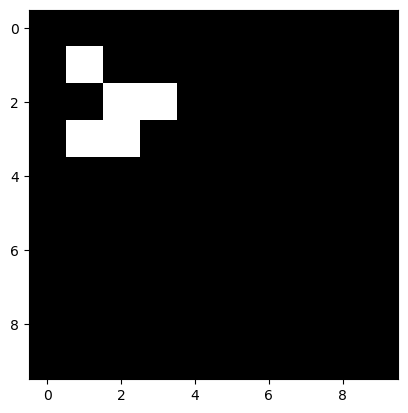

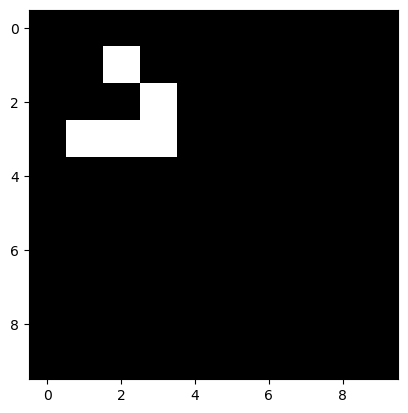

In [2]:
class Board(np.ndarray):

    image: Image
    new_board: np.ndarray
    background_color: int = 0
    tick_lock: Lock

    def __new__(cls, random: bool, height: int, width: int):
        """
        cls: Nom de la classe
        random: défini s'il y a des cases vivantes ou non au début du jeu
        height,width: hauteur et largeur du board
        """
        width, height = width + 2, height + 2 #création des bordures
        if random:
            return np.random.choice([False, True], (height, width), p=[0.5, 0.5]).view(cls) #création du board avec des cellules vivantes et mortes en random
        else:
            return np.zeros((height, width), dtype=bool).view(cls) #création du board uniquement avec cellules mortes

    def __init__(self, *args, **kwargs):
        """
        see __new__
        """
        # Create second array to store the next state and be space efficient
        self.new_board = np.zeros_like(self, dtype=bool)
        # Create a lock to make sure the board is not updated while ticking
        self.tick_lock = Lock()

        self.image = None #Efface la dernière pour forcer le recalcul de l'image

    def updateCPU(self):
        """
        Ticks the board to compute next state using cpu (slower but works everywhere).
        """
        for i, j in np.ndindex(self.shape):
            alive_count = self.countAlive(i, j)
            self.new_board[i, j] = alive_count in [2, 3] if self[i, j] else alive_count == 3
        self[...] = self.new_board

    def countAlive(self, i: int, j: int) -> bool:
        """
        Get the amount of alive neighbors of a cell.
        """
        return self[i - 1:i + 2, j - 1:j + 2].sum() - self[i, j]

    def tick(self):
        """
        Ticks the board to compute next state.
        """
        self.tick_lock.acquire()
        self.updateCPU()
        self.refresh()
        self.tick_lock.release()

    def getImage(self, is_transparent: bool = False) -> Image:
        """
        Converts the board to an image.
        can be transparent or not.
        """
        if self.image is not None:
            return self.image
        bg = self.background_color

        # first convert the board to a grayscale image

        img_data = self.astype(np.uint8) * 255
        # set custom background color if single grayscale value
        if not is_transparent and isinstance(bg, int) and bg != 0:
            img_data[img_data == 0] = self.background_color
        # create the grayscale image and crop the borders
        image = Image.fromarray(img_data, mode='L').crop((1, 1, self.shape[0] - 1, self.shape[1] - 1))
        # colorize the image if background is a color
        if not is_transparent and isinstance(bg, tuple):
            self.image = ImageOps.colorize(image, black=bg, white=(255, 255, 255))
        else:
            self.image = image.convert('RGB')
        # add alpha channel if needed just by using the same image as alpha
        if is_transparent:
            self.image.putalpha(image)

        # return the image
        return self.image

    def paste(self, other: 'Board', y: int, x: int):
        """
        Paste another board on top of this one.
        """
        self.tick_lock.acquire()
        self[x + 1:x + other.shape[0] - 1, y + 1:y + other.shape[1] - 1] = other[1:-1, 1:-1]
        self.refresh()
        self.tick_lock.release()

    def getSize(self) -> tuple[int, int]:
        """
        Get the size of the board.
        """
        return self.shape[1] - 2, self.shape[0] - 2

    def getAliveCount(self) -> int:
        """
        Get the amount of alive cells in the board.
        """
        return self.sum()

    def refresh(self):
        """
        empty the image cache
        """
        self.image = None

board = Board(False,10,10)
board[1:4, 1:4] = [
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 1]
]

for _ in range(5):
    plt.imshow(board.getImage())
    board.tick()
    plt.show()

# Partie B : Interface

l'interface utilise pygame pour le rendu et des éléménts utilise un système de parenté pour les intéractions, le rendu et les transformations.

les 3 composant principaux sont :
- la classe `Child` qui est la classe parente de tous les éléments de l'interface et implémente les méthodes de base pour les interaction le rendu et les transformations
- la classe `ScaledChild` qui est la classe parente de tous les éléments de l'interface qui peuvent être redimensionnés
- la classe `Container` qui est la classe permettant de contenir d'autres éléments de l'interface

D'autres classe implémente les éléments de bases de l'interface:
- `StaticTextRender`: permet d'afficher du texte statique
- `BoldStaticTextRender`: permet d'afficher du texte statique en gras (affiche un deuxième texte en décalé pour donner un effet d'ombre)
- `Button`: permet de créer un bouton interactif
- `RadioButton`: une sous classe de `Button` qui permet de créer un bouton radio (un seul bouton radio peut être actif à la fois dans un groupe)
- `Toggle`: une sous classe de `Button` qui permet de créer un bouton qui change d'état à chaque click
- `Input`: permet de créer un champ de texte interactif
- `Graph`: permet de créer un graphique de donnée (le plus complexe des éléments)

Enfin il existe des composants dis "complexes" tel que:
- `TimeBarRender`: représente les contrôles de temps (play, pause, step, avancer plus ou moin vite)
- `TpsRender`: représente le nombre de tick par seconde éffectué
- `BoardRender`: permet de faire un rendu dynamique du board du jeu de la vie
- `PresetRender`: une sous classe de `BoardRender` qui permet d'afficer une preset sur la board pour ensuite le placer
- `PresetContainer`: une sous classe de `Container` qui permet de contenir des `PresetRender` et de les choisir pour ensuite les placer sur la board
- `SavePopup`: une sous classe de `Container` qui permet de sauvegarder une board sois en tant que preset ou en format board

### Une  image pour mieux comprendre l'interface:
![Interface](assets/interface.png)

passons en revue les éléments principaux de l'interface:

In [6]:
class Child:
    coord: tuple[int, ...]
    size: tuple[int, ...]
    parent: 'Container'
    can_interact: bool = False
    uuid: UUID

    def __init__(self, coord: tuple[int, ...], size: tuple[int, ...], parent: 'Container'):
        self.parent = parent
        self.size = tuple(math.floor(s * parent.ratio) for s in size)
        self.coord = tuple(math.floor(s * parent.ratio) + p for s, p in zip(coord, parent.coord))
        self.uuid = uuid.uuid4()

    def handleEvents(self):
        pass # stub

    def render(self, screen: pygame.Surface):
        pass # stub

    @property
    def rect(self) -> tuple:
        return *self.coord, *self.size

    def cleanup(self):
        """
        Remove the child from its parent.
        """
        self.parent.children.remove(self)

    def __eq__(self, other):
        return isinstance(other, self.__class__) and self.uuid == other.uuid

    def __hash__(self):
        return hash(self.uuid)


class ScaledChild(Child):
    ratio: float
    content_size: tuple[int, ...]

    def __init__(self, coord: tuple[int, ...], size: tuple[int, ...],
                 content_size: tuple[int, ...], parent: 'Container'):
        self.ratio = fitRatio(size, content_size)
        self.content_size = content_size
        content_size = tuple(math.floor(s * self.ratio) for s in content_size)
        super().__init__(coord, content_size, parent)
        self.ratio *= parent.ratio
        self.coord = centerCoord(self.coord, tuple(math.floor(s * parent.ratio) for s in size), self.size)


class Container(ScaledChild):
    background: pygame.Surface
    children: list[Child]

    def __init__(self, coord: tuple[int, ...], size: tuple[int, ...] | None,
                 parent: 'Container', bg: Path | pygame.Surface):
        if isinstance(bg, Path):
            bg = pygame.image.load(str(bg))
        if size is None:  # consider a 1:1 background with its parent
            size = bg.get_size()
        super().__init__(coord, size, bg.get_size(), parent)
        self.background = pygame.transform.scale(bg, tuple(int(x * self.ratio) for x in bg.get_size()))
        self.children = []

    @staticmethod
    def fromScreen(screen: pygame.Surface, path: Path) -> 'Container':
        """
        Create a container from a screen and a background image.
        :param screen: the screen to get the size from
        :param path: the path to the background image
        :return: the container built from the screen and the background image
        """
        container: Container = Container.unit(screen.get_size())
        return Container(container.coord, container.size, container, path)

    @staticmethod
    def unit(size: tuple = (0, 0)) -> 'Container':
        """
        Create a container with a 1:1 ratio without any parent.
        :param size: the expected size
        :return: the container built
        """
        container: Container = object.__new__(Container)
        container.__class__ = Container
        container.coord = (0, 0)
        container.size = size
        container.ratio = 1
        return container

    def handleEvents(self):
        """
        Call the handleEvents method of all children in reverse order. (to handle the top children first)
        """
        for child in self.children[::-1]:
            child.handleEvents()

    def add(self, child):
        """
        Add a child to the container.
        :param child: the child to add
        """
        self.children.append(child)

    def render(self, screen: pygame.Surface):
        """
        Render the container and all its children in added order.
        :param screen: the surface to render on
        """
        screen.blit(self.background, self.coord)
        for child in self.children:
            child.render(screen)

    def clear(self, type: type = None):
        """
        Clear the children of the container.
        :param type: if specified, only remove children of this type
        """
        if type is None:
            self.children.clear()
            return
        self.children = [c for c in self.children if not isinstance(c, type)]

    def get(self, type: type = None) -> list:
        """
        Get the children of the container.
        :param type: if specified, only return children of this type
        :return: the children of the container
        """
        if type is None:
            return self.children
        return [c for c in self.children if isinstance(c, type)]
    
# run for demo
import Main
Main.run()

Loaded preset flower
Loaded preset glider
Loaded preset glider_gun


Partie C : Sauvegarde et Chargement

In [ ]:
from Grille import *

def sauvegarde(grille,fichier):
  svg = open(fichier,"w")
  svg.write("Nbres de jours : " + str(grille.jour)+"\n\n" )

  s = ""
  for i in range (0,grille.dimension):
    for j in range (0,grille.dimension):
      s+=str(grille.matrice[i])
      [j].couleur
      s+="\n"
    svg.write(s)

    svg.close()

def chargement(fichier):
  with open(fichier,'r') as chg:
    ligne = chg.readline()
    ligne = ligne.replace("Nbres de jours : ","")
    ligne = ligne.replace("\n\n","")
    jour = int(ligne)

    ligne = chg.readline()

    ligne = chg.redline()

    dimension = len(ligne) - 1
    matrice = []

    i = 0
    while ligne:
      l = []
      j = 0

      for n in ligne [:len(ligne) - 1]:
        cell = Cellule(0,int(n),i,j)
        j+=1
        l.append(cell)

      matrice.append(l)
      ligne = chg.readline
      i+=1

  chg.close()

  grille = Grille(dimension, jour,matrice)
  return grille

# Partie D: Optimisation

Pour optimiser le code, nous avons utilisé la librairie `numba` qui permet de compiler le code en utilisant le GPU pour les calculs en parallèle sur le GPU.
Cela permet d'accélérer le calcul de la prochaine itération du jeu de la vie. dans n'importe quelle distribution de cellules, le calcul est plus rapide que la version CPU. et la différence est plus visible lorsque la taille de la board est très grande.

Pour expliquer simplement le CPU est un processeur qui effectue des calculs séquenciel, tandis que le GPU est un processeur qui effectue des calculs en parallèle, c'est-à-dire plusieurs à la fois. Cela permet de réduire le temps de calcul. mais sachez que le GPU n'est bon qu'as faire des calculs **identiques** sur plusieurs éléments.

Calcul pour petite board (50x50)


D:\Miniconda3\envs\game_of_life\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


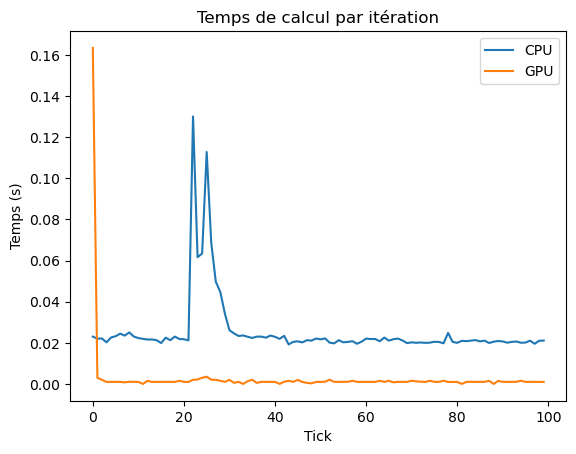

Calcul pour grande board (1024x1024)


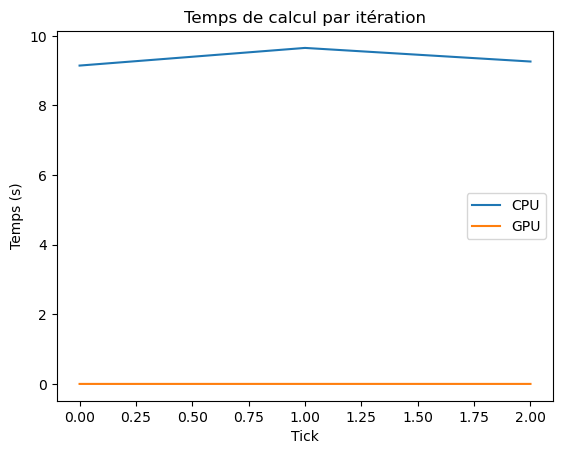

Calcul pour très très grande board (GPU uniquement) (8192x8192)


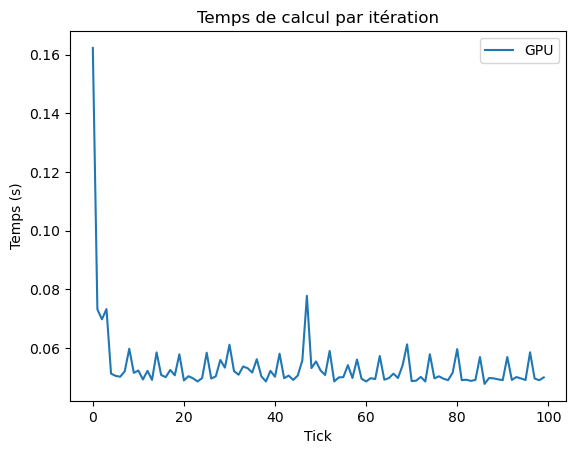

In [17]:
class Board(np.ndarray):
    """
    Implements the storage and logic of the Game of Life board.
    """
    use_gpu: bool
    new_board: np.ndarray

    def __new__(cls, _: bool, random: bool, height: int, width: int):
        width, height = width + 2, height + 2
        if random:
            return np.random.choice([False, True], (height, width), p=[0.5, 0.5]).view(cls)
        else:
            return np.zeros((height, width), dtype=bool).view(cls)

    def __init__(self, try_cuda: bool = True, *args, **kwargs):
        # Create second array to store the next state and be space efficient
        self.new_board = np.zeros_like(self, dtype=bool)

        self.use_gpu = try_cuda and cuda.is_available()
        if try_cuda and not self.use_gpu:
            print("CUDA is not available, defaulting to CPU instead.")

    def updateCPU(self):
        """
        Ticks the board to compute next state using cpu (slower but works everywhere).
        """
        for i, j in np.ndindex(self.shape):
            alive_count = self.countAlive(i, j)
            self.new_board[i, j] = alive_count in [2, 3] if self[i, j] else alive_count == 3

        self[...] = self.new_board

    def countAlive(self, i: int, j: int) -> bool:
        """
        Get the amount of alive neighbors of a cell.
        """
        return self[i - 1:i + 2, j - 1:j + 2].sum() - self[i, j]

    @staticmethod
    @cuda.jit
    def updateGpu(board, new_board, width: int, height: int):
        """
        Ticks part of the board to compute next state using cuda.
        """
        x, y = cuda.grid(2)
        if 0 < x < width - 1 and 0 < y < height - 1:
            alive_count = 0
            for i in range(-1, 2):
                for j in range(-1, 2):
                    alive_count += board[x + i, y + j]
            alive_count -= board[x, y]
            new_board[x, y] = alive_count in [2, 3] if board[x, y] else alive_count == 3

    def tick(self):
        """
        Ticks the board to compute next state.
        """
        if self.use_gpu:  # use cuda if available (determined at init)
            self[...] = Board.runOnGpu(
                cuda.to_device(self),
                cuda.to_device(self.new_board),
                self.shape,
                Board.updateGpu
            )
        else:
            self.updateCPU()
            
    @staticmethod
    def runOnGpu(src, dest, shape: tuple[int, ...], func: Callable, *args) -> np.ndarray:
        """
        Runs a function on the GPU.
        """
        threads_per_blocks = (16, 16)
        blocks_per_grid = (
            (shape[0] + threads_per_blocks[0] - 1) // threads_per_blocks[0],
            (shape[1] + threads_per_blocks[1] - 1) // threads_per_blocks[1]
        )
        func[blocks_per_grid, threads_per_blocks](src, dest, *shape, *args)
        return dest.copy_to_host()

    def getAliveCount(self) -> int:
        """
        Get the amount of alive cells in the board.
        """
        return int(self.sum())
    
# run for demo
cpu_board = Board(False, True, 50, 50)
gpu_board = Board(True, True, 50, 50)

timing = {"cpu": [], "gpu": []}
print("Calcul pour petite board (50x50)")
for _ in range(100):
    start_time = time.time()
    cpu_board.tick()
    timing["cpu"].append(time.time() - start_time)
    start_time = time.time()
    gpu_board.tick()
    timing["gpu"].append(time.time() - start_time)
    
plt.plot(timing["cpu"], label="CPU")
plt.plot(timing["gpu"], label="GPU")
plt.xlabel("Tick")
plt.ylabel("Temps (s)")
plt.title("Temps de calcul par itération")
plt.legend()
plt.show()

cpu_board = Board(False, True, 1024, 1024)
gpu_board = Board(True, True, 1024, 1024)

timing = {"cpu": [], "gpu": []}
print("Calcul pour grande board (1024x1024)")
for _ in range(3):
    start_time = time.time()
    cpu_board.tick()
    timing["cpu"].append(time.time() - start_time)
    start_time = time.time()
    gpu_board.tick()
    timing["gpu"].append(time.time() - start_time)
    
plt.plot(timing["cpu"], label="CPU")
plt.plot(timing["gpu"], label="GPU")
plt.xlabel("Tick")
plt.ylabel("Temps (s)")
plt.title("Temps de calcul par itération")
plt.legend()
plt.show()

gpu_board = Board(True, True, 8192, 8192)
timing = {"gpu": []}

print("Calcul pour très très grande board (GPU uniquement) (8192x8192)")
for _ in range(100):
    start_time = time.time()
    gpu_board.tick()
    timing["gpu"].append(time.time() - start_time)
    
plt.plot(timing["gpu"], label="GPU")
plt.xlabel("Tick")
plt.ylabel("Temps (s)")
plt.title("Temps de calcul par itération")
plt.legend()
plt.show()
    

# Partie E : Analyse de données

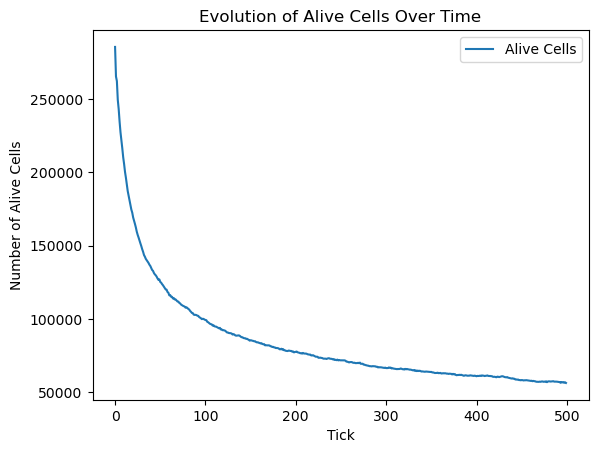

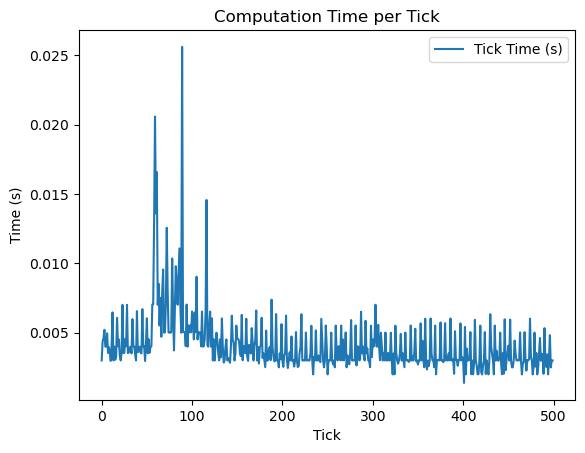

In [16]:
class GameAnalysis:
    """
    A class to analyze and visualize the progression of the Game of Life.
    """
    def __init__(self, board):
        self.board = board
        self.alive_counts = []
        self.tick_times = []

    def count_alive_cells(self):
        """
        Compte le nbres de cellules vivantes dans le board
        """
        alive_count = self.board.getAliveCount()
        self.alive_counts.append(alive_count)
        return alive_count

    def track_tick_time(self, start_time, end_time):
        """
    Le temps de calcul pour chaque itération
        """
        tick_time = end_time - start_time
        self.tick_times.append(tick_time)
        return tick_time

    def plot_alive_cells(self):
        """
       Graphes représentant le nbres de cellules vivantes  à travers le temps
        """
        plt.figure()
        plt.plot(self.alive_counts, label="Alive Cells")
        plt.xlabel("Tick")
        plt.ylabel("Number of Alive Cells")
        plt.title("Evolution of Alive Cells Over Time")
        plt.legend()
        plt.show()

    def plot_tick_times(self):
        """
        Graphes représentant le temps de calcul pour chaque itération
        """
        plt.figure()
        plt.plot(self.tick_times, label="Tick Time (s)")
        plt.xlabel("Tick")
        plt.ylabel("Time (s)")
        plt.title("Computation Time per Tick")
        plt.legend()
        plt.show()

    def reset_tracking(self):
        """
        ResRéinitialises les listes et graphes de suivies pour une nouvelle simulation
        """
        self.alive_counts = []
        self.tick_times = []

board = Board(True, True, 1024, 1024)
analysis = GameAnalysis(board)

for _ in range(500):
    start_time = time.time()
    board.tick()
    end_time = time.time()

    analysis.count_alive_cells()
    analysis.track_tick_time(start_time, end_time)

# Affiche les graphes
analysis.plot_alive_cells()
analysis.plot_tick_times()

